In [1]:
from scipy import special
from scipy import optimize
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def switch_freq(subj):
    i = subj[2]
    switcher = {
        'L':range(10,20+1,1),
        'H':range(25,35+1,1)
    }
    return switcher.get(i,"Invalid day of week")

In [28]:
MATLAB_drive = '/Users/clmn/MATLAB-Drive'
behav_dir = MATLAB_drive + '/TM experiment/TM_behavior/behav_data/'
subj = 'TMH01_pilot'

In [29]:
freq_range = switch_freq(subj)
freq_c = freq_range[5]

In [31]:
def calc_freq_class(freq_range, freq):
    #freq_range = range(10,20+1,1)
    freqs = [x for x in freq_range]
    f_mid = int((freqs[0]+freqs[-1])*0.5)
    return int(freq - f_mid)

## Psychometric Curve Fitting

In [49]:
def get_dataframe_DIS(subj):
    subj_behav_datum = behav_dir + subj + '/%s_Dis.dat' %subj
    df = pd.read_csv(subj_behav_datum, sep='\t', header=None)
    df.columns=['trial', 'Freq.1', 'ISI1', 'Freq.2', 'ISI2', 'decision', 'correctness', 'RT', 'ISI3']
    df['Freq.1.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.1']]
    df['Freq.2.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.2']]
    df['Freq.other.index'] = [1 if a != 0 else 2 for a in df['Freq.1.class']]
    df['Freq.other.class'] = [a+b for a, b in zip(df['Freq.1.class'], df['Freq.2.class'])]
    df['answer.index'] = [1 if a>b else 2 for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['decision.index'] = [1 if x == 'before' else (2 if x=='after' else 'NaN') for i, x in enumerate(df['decision'])]
    df['Freq.other_decision.class'] = ['NaN' if b=='NaN' else (1 if a==b else -1) for a,b in zip(df['Freq.other.index'],df['decision.index'])]

    df['Freq.1.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.1']]
    df['Freq.2.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.2']]
    df['Freq.other.rank'] = [a+b for a, b in zip(df['Freq.1.rank'], df['Freq.2.rank'])]
    df['F1<F2.class'] = [np.sign(b-a) for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['F1<F2.rank'] = [b-a for a, b in zip(df['Freq.1'], df['Freq.2'])]

    return df

def scatter_x_y(subj):
    df = get_dataframe_DIS(subj)
    da = df[['answer.index','decision.index','Freq.other.rank']]
    
    x = range(-5,6)

    db = pd.DataFrame(index = ['prob'], columns = range(-5,6))
    for rank in x:
        temp = (da['decision.index'] != 'NaN')&(da['Freq.other.rank'] == rank)&(da['answer.index'] == da['decision.index'])
        n = len(da[temp])
        db[rank] = n * np.sign(rank)
    maxfreq = max(freq_range)
    db = db/maxfreq * 0.5 + 0.5
    prob = np.array(db).reshape(len(x))
    return x, prob

def test_func(x, s):
    return 0.5*(1+special.erf(x/(np.sqrt(2)*s)))
def test_func(x, a,b,r,k):
    n = 15
    return 0.5*(1+special.erf( k/(a*k**r)**(0.5) * (x**b-n**b)/np.sqrt(x**(b*r)+n**(b*r)) ))

<ipython-input-49-3695fa21435c>:41: RuntimeWarning: invalid value encountered in power
  return 0.5*(1+special.erf( k/(a*k**r)**(0.5) * (x**b-n**b)/np.sqrt(x**(b*r)+n**(b*r)) ))
/Users/clmn/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


TypeError: test_func() missing 3 required positional arguments: 'b', 'r', and 'k'

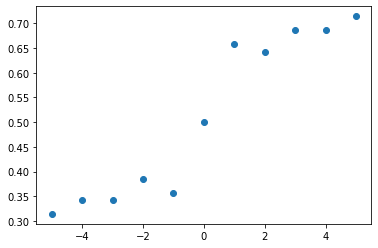

In [50]:
t, prob = scatter_x_y(subj)
params, params_covariance = optimize.curve_fit(test_func, t, prob, p0=[0.1,0.1,0.1,0.1], maxfev=1000)
#params, params_covariance = optimize.curve_fit(test_func, t, prob, p0=[0.2], maxfev=1000)
JND=special.erfinv(0.5)*(np.sqrt(2)*params[0]); # JND for 75%

plt.scatter(x=t,y=prob)
plt.plot(t, test_func(t, params[0]), label='\u03C3=%.3fHz\nJND=%.3fHz'%(params[0],JND))
plt.legend(loc='best')
plt.title(subj)
plt.grid()
plt.savefig(fname=subj+'_curve.png',dpi=300)

## Hidden Target Search Task